In [1]:
import pandas as pd
import numpy as np

seasons = pd.read_csv('Data/nba_player_stats_by_season.csv', index_col = 'id')
# careers = pd.read_csv('Data/nba_player_stats_by_career.csv', index_col = 'id')

# Create a few extra columns
def get_min_age(player_id):
    return seasons[seasons['player_id'] == player_id]['age'].min()

seasons['min_age'] = seasons['player_id'].apply(get_min_age)
# careers['min_age'] = careers['player_id'].apply(get_min_age)

# remove seasons with less than 400 minutes (~5 mpg), 3310 in total
seasons.dropna(subset=['minutes_played'], inplace = True) # removes 609 seasons where the player didn't play at all
seasons = seasons[seasons['minutes_played'] >= 400] # removes another 2701 seasons

def get_total_seasons(player_id):
    return seasons[seasons['player_id'] == player_id].shape[0]

seasons['total_seasons'] = seasons['player_id'].apply(get_total_seasons)

def index_seasons(player_id, year):
    season_list = list(seasons[seasons['player_id'] == player_id]['year'])
    season_list.sort()
    return season_list.index(year)

seasons['season_index'] = [index_seasons(player_id, year) for player_id,
                           year in zip(seasons['player_id'], seasons['year'])]

In [2]:
# convert minutes played to % of available minutes played
# helps to account for seasons shortened by injury or lockout
# assume maximum minutes per game is 40, this helps prevent model from over-predicting minutes.

seasons['minutes_proportion'] = seasons['minutes_played'] / (seasons['games_played'] * 40)

# Create Training and Testing Sets

split on players

In [3]:
# creat a list of all players who have a minimum number of seasons, try 5
# use these players for model training, cross validation, and testing

data = seasons[seasons['total_seasons'] >= 5]
player_list = data['player_id'].unique()

len(player_list) # 800 players with at least 5 seasons

822

In [4]:
from sklearn.model_selection import train_test_split

# Split players into training and test sets
train_players_list, test_players_list = train_test_split(player_list, random_state = 42)

print("training size: ", len(train_players_list))
print("testing size: ", len(test_players_list))

training size:  616
testing size:  206


In [5]:
def train_or_test(player_id):
    if player_id in train_players_list:
        return 'train'
    else:
        return 'test'

data['train_test'] = data['player_id'].apply(train_or_test)

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [6]:
# choose columns to use
# below is a mostly complete list of basic box score statistics
# attempts and percentages can be used to derive makes
# makes can be summed with shot value to derive points
# defensive and offensive rebounds can be combined for total rebounds

keep_cols = ['player_id', 'train_test', 'year', 'min_age', 'total_seasons', 'season_index', 'age', 'minutes_played',
             'minutes_proportion', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
             'three_point_attempts', 'free_throw_percentage', 'free_throw_attempts', 'defensive_rebounds',
             'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

data = data[keep_cols]

### Account for Small Shooting Sample Sizes

In [7]:
seasons[seasons['two_point_attempts'] < 25]['two_point_percentage']

id
clarkga01 2019    0.692
clarkga01 2020    0.667
millemi01 2015    0.313
novakst01 2014    0.333
biedran01 2013    0.476
cardibr01 2011    0.077
Name: two_point_percentage, dtype: float64

In [8]:
# Lots of seasons with verys small sample sizes of 3pt shooting, also lots of NaNs
seasons[seasons['three_point_attempts'] < 25]['three_point_attempts'].value_counts()

0.0     791
1.0     545
2.0     383
3.0     230
4.0     186
5.0     142
6.0     118
7.0     111
8.0      73
9.0      66
10.0     61
13.0     55
11.0     52
12.0     51
14.0     45
23.0     44
15.0     41
21.0     40
16.0     39
17.0     38
22.0     38
19.0     33
20.0     30
24.0     24
18.0     23
Name: three_point_attempts, dtype: int64

In [9]:
# a few seasons with very low sample size of free throw shooting
seasons[seasons['free_throw_attempts'] < 25]['free_throw_attempts'].value_counts()

21.0    30
20.0    29
24.0    29
23.0    26
19.0    24
22.0    23
16.0    21
15.0    19
18.0    19
13.0    16
8.0     15
14.0    13
17.0    13
12.0    11
11.0    11
9.0      9
7.0      6
10.0     6
5.0      6
6.0      4
4.0      3
2.0      1
Name: free_throw_attempts, dtype: int64

In [10]:
data['three_point_percentage'].fillna(value = 0.12, inplace = True)

def fix_low_3pa(attempts, rate):
    if attempts <= 5:
        return 0.15
    
    elif attempts <= 15:
        if rate >= 0.25:
            return 0.25
        else:
            return np.max([0.12, rate])
        
    elif attempts <= 25:
        if rate >= 0.35:
            return 0.35
        else:
            return np.max([0.1, rate])
        
    else:
        return rate

data['three_point_percentage'] = [fix_low_3pa(attempts, rate) for attempts,
                                  rate in zip(data['three_point_attempts'], data['three_point_percentage'])]

def fix_low_fta(attempts, rate):
    if attempts <= 10:
        return 0.75
    
    elif attempts <= 25:
        if rate >= 0.8:
            return 0.8
        else:
            return np.max([0.7, rate])
        
    elif attempts <= 50:
        if rate >= 0.85:
            return 0.85
        else:
            return np.max([0.60, rate])
        
    else:
        return rate

data['free_throw_percentage'] = [fix_low_fta(attempts, rate) for attempts,
                                  rate in zip(data['free_throw_attempts'], data['free_throw_percentage'])]

def fix_low_2pa(attempts, rate):
    if attempts <= 25:
        if rate >= 0.6:
            return 0.6
        else:
            return np.max([0.3, rate])
    else:
        return rate

data['two_point_percentage'] = [fix_low_fta(attempts, rate) for attempts,
                                  rate in zip(data['two_point_attempts'], data['two_point_percentage'])]

In [11]:
# Multiply three point percentage by 1.8
# This will effectively cap three point percentage at 55.5%
# Helps prevent model from over-predicting 3pt percentage

data['three_point_percentage'] = data['three_point_percentage'] * 1.8

### Convert to per 36 Minutes

In [12]:
# convert counting stats to per 36 minute
data['two_point_attempts'] = data['two_point_attempts'] / data['minutes_played'] * 36
data['three_point_attempts'] = data['three_point_attempts'] / data['minutes_played'] * 36
data['free_throw_attempts'] = data['free_throw_attempts'] / data['minutes_played'] * 36
data['defensive_rebounds'] = data['defensive_rebounds'] / data['minutes_played'] * 36
data['offensive_rebounds'] = data['offensive_rebounds'] / data['minutes_played'] * 36
data['assists'] = data['assists'] / data['minutes_played'] * 36
data['steals'] = data['steals'] / data['minutes_played'] * 36
data['blocks'] = data['blocks'] / data['minutes_played'] * 36
data['turnovers'] = data['turnovers'] / data['minutes_played'] * 36
data['personal_fouls'] = data['personal_fouls'] / data['minutes_played'] * 36

In [13]:
# convert proportions to log odds using logit function
# define sigmoid function for reverse transformation

def logit(p):
    if p > 0.95:
        p = 0.95
    if p < 0.05:
        p = 0.05
    return np.log(p/(1-p))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [14]:
data['minutes_proportion'] = data['minutes_proportion'].apply(logit)
data['two_point_percentage'] = data['two_point_percentage'].apply(logit)
data['three_point_percentage'] = data['three_point_percentage'].apply(logit)
data['free_throw_percentage'] = data['free_throw_percentage'].apply(logit)

### Create Features for Past Performance

In [15]:
def create_past_features(features, n, data):
    '''
    Creates columns in data for previous player performance for input features.
    n defines how far back to go.
    '''
    
    def select_past(player_id, feat, season_ix, n):
        
        if season_ix - n < 0:
            return np.NaN
        
        else:
            mask = np.array(data['player_id'] == player_id) & np.array(data['season_index'] == season_ix - n)
            return data[mask][feat][0]
    
    def create_past_feat(feat, n):
        
        past_feat = feat + '_p' + str(n)
        data[past_feat] = [select_past(p_id, feat, s_ix, n) for p_id, s_ix in zip(data['player_id'], data['season_index'])]
        
    for feature in features:
        for i in range(1, n + 1):
            create_past_feat(feature, i)
            
    return data

# pick out only the columns that will be fed into the model for predictions
features = ['minutes_proportion', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
              'three_point_attempts', 'free_throw_percentage','free_throw_attempts', 'defensive_rebounds',
              'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

data = create_past_features(features, 1, data)

In [16]:
data['age2'] = data['age'] ** 2
data['age3'] = data['age'] ** 3

### Split Train and Test

In [17]:
train = data[data['train_test'] == 'train']
test = data[data['train_test'] == 'test']

### Determine Average Career Length in Each Set

In [18]:
# For training set
career_lengths = []

for player in train['player_id'].unique():
    career_lengths.append(train[train['player_id'] == player]['total_seasons'][0])
    
np.mean(career_lengths)

9.782467532467532

In [19]:
# For testing set
career_lengths = []

for player in test['player_id'].unique():
    career_lengths.append(test[test['player_id'] == player]['total_seasons'][0])
    
np.mean(career_lengths)

9.83495145631068

In [20]:
# For overall dataset
career_lengths = []

for player in data['player_id'].unique():
    career_lengths.append(data[data['player_id'] == player]['total_seasons'][0])
    
np.mean(career_lengths)

9.795620437956204

In [21]:
data['total_seasons'].max()

22

# Feature Correlations

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

cfeatures = ['age', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
              'three_point_attempts', 'free_throw_percentage','free_throw_attempts', 'defensive_rebounds',
              'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

plt.figure(figsize=(11,9))
plt.title('Feature Correlations')
sns.heatmap(data[cfeatures].corr(), annot = True, cmap = 'RdYlBu');

In [23]:
from collections import defaultdict

# For each feature identify strongly correlated features

corrs = data.corr()
corr_dict = defaultdict(list)

for feature in features:
    feat_corrs = corrs[feature]
    for feat, corr in zip(feat_corrs.index, feat_corrs.values):
        if np.abs(corr) > 0.3 and feat != feature and feat[-2] == 'p':
            corr_dict[feature].append((feat, corr))

for key in corr_dict.keys():
    corr_dict[key] = sorted(corr_dict[key], key=lambda tup: -tup[1])

In [24]:
corr_dict['two_point_attempts']

[('two_point_attempts_p1', 0.8735978778811008),
 ('free_throw_attempts_p1', 0.5830658721201669),
 ('turnovers_p1', 0.434402235594975),
 ('minutes_proportion_p1', 0.37350962550348216),
 ('three_point_attempts_p1', -0.38561584750492245)]

# Create Model for Two Point Attempts

## LINEAR REGRESSION

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
lin_model = LinearRegression()

In [27]:
tpa_feats = ['age', 'age2', 'age3', 'two_point_attempts_p1', 'free_throw_attempts_p1']

In [28]:
X_train = train[train['season_index'] >= 1][tpa_feats]
y_train = train[train['season_index'] >= 1]['two_point_attempts']
X_test = test[test['season_index'] >= 1][tpa_feats]
y_test = test[test['season_index'] >= 1]['two_point_attempts']

In [29]:
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [31]:
def evaluate_general_model(model, X_data, y_data, sig = False, mae = True):
    
    preds = model.predict(X_data)
    
    if sig == True:
        preds = sigmoid(preds)
        y_data = sigmoid(y_data)
    
    if mae:
        return mean_absolute_error(y_data, preds)
    else:
        return mean_squared_error(y_data, preds)

In [32]:
evaluate_general_model(lin_model, X_train, y_train)

1.2566417499701215

In [33]:
evaluate_general_model(lin_model, X_test, y_test)

1.2453173943832998

## RANDOM FOREST REGRESSION

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
rf_model = RandomForestRegressor(n_estimators = 50, max_depth = 5)

In [36]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [37]:
evaluate_general_model(rf_model, X_train, y_train)

1.2248886912946888

In [38]:
evaluate_general_model(rf_model, X_test, y_test)

1.2671101187722758

## GRADIENT BOOSTED TREE

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
grad_model = GradientBoostingRegressor(n_estimators=100)

In [41]:
grad_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
evaluate_general_model(grad_model, X_train, y_train)

1.2003889138703596

In [43]:
evaluate_general_model(grad_model, X_test, y_test)

1.2681779070375492

## NOTES

It appears that the linear model has the best performance.

Create some synthetic data to see impact of age on future predictions.

In [44]:
data['two_point_attempts'].mean()

9.425971883497416

In [45]:
data['free_throw_attempts'].mean()

3.5875056835094803

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


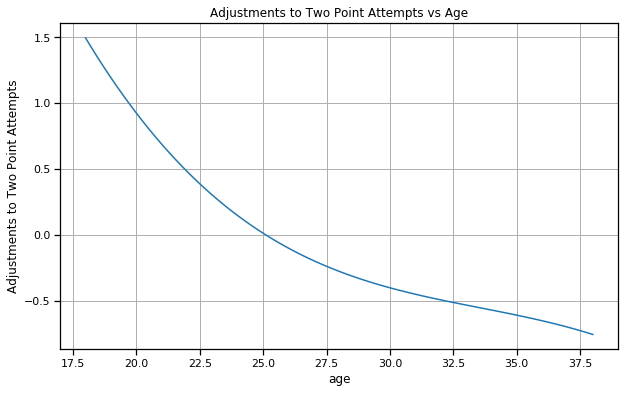

In [96]:
syn_age = np.linspace(18, 38, 100)
syn_age2 = np.linspace(18, 38, 100) ** 2
syn_age3 = np.linspace(18, 38, 100) ** 3
tpas = np.ones((100,1))* 9.4
ftas = np.ones((100,1))* 3.6

syn_data = np.hstack((syn_age.reshape(-1,1), syn_age2.reshape(-1,1), syn_age3.reshape(-1,1), tpas, ftas))
syn_data = pd.DataFrame(syn_data, columns=tpa_feats)

preds = lin_model.predict(syn_data)

syn_data['two_point_attempts'] = preds

syn_preds = syn_data[['age', 'two_point_attempts']]

syn_preds['two_point_attempts'] = np.array(syn_preds['two_point_attempts']) - 9.4


plt.figure(figsize=(10,6))
plt.title('Adjustments to Two Point Attempts vs Age')
plt.grid()
sns.lineplot(x = syn_preds['age'], y = syn_preds['two_point_attempts'])
plt.ylabel('Adjustments to Two Point Attempts');

# Create General Model for All Stats

## Create Dictionary of Features

which past features to use for predictions of each new feature

In [47]:
# # try dumping all correlated features into feat_dict for every feature.
# feat_dict = defaultdict(list)
# for feat in list(corr_dict.keys())[1:]:
#     for corr in corr_dict[feat]:
#         if corr[0] != 'minutes_proportion_p1':
#             feat_dict[feat].append(corr[0])

In [48]:
# try dumping ALL features into feat_dict for every feature.
feat_dict = {}
for feat in list(corr_dict.keys())[1:]:
    feat_dict[feat] = ['two_point_percentage_p1', 'two_point_attempts_p1',
       'three_point_percentage_p1', 'three_point_attempts_p1',
       'free_throw_percentage_p1', 'free_throw_attempts_p1',
       'defensive_rebounds_p1', 'offensive_rebounds_p1', 'assists_p1',
       'steals_p1', 'blocks_p1', 'turnovers_p1', 'personal_fouls_p1']

In [49]:
for key in feat_dict.keys():
    feat_dict[key] = feat_dict[key] + ['age', 'age2', 'age3']

In [50]:
targets = list(feat_dict.keys())

## Define Multi Model Class

In [51]:
class MultiModelContainer:
    
    '''
    Object to function as a container for multiple linear models.
    Initialize with a dictionary where keys are targets and values are lists of features.
    '''
    
    def __init__(self, feature_dict, data):
        
        self.model_dict = {}
        self.feature_dict = feature_dict
        
        # initialize and fit models
        for target in feature_dict.keys():
            features = feature_dict[target]
            self.model_dict[target] = LinearRegression().fit(data[features], data[target])    

    def predict(self, targets, data, output_df = False, input_df = True, feature_map = None):
        
        switch = False
        
        for target in targets:
            # select features for target
            features = self.feature_dict[target]
            
            if input_df:
                # select model and input data for prediction
                preds = self.model_dict[target].predict(data[features])
            else:
                # if not using a df use feature map to select data from an array
                X = np.hstack(tuple([data[:,feature_map[feature]] for feature in features]))
                preds = self.model_dict[target].predict(X.reshape(-1,len(features)))
            
            if not switch:
                predictions = preds.reshape(-1,1)
                switch = True
                
            else:
                predictions = np.hstack((predictions, preds.reshape(-1,1)))
        
        if not output_df:
            return predictions
        
        else:
            return pd.DataFrame(predictions, columns = targets, index = data.index)

In [52]:
feat_dict.keys()

dict_keys(['two_point_percentage', 'two_point_attempts', 'three_point_percentage', 'three_point_attempts', 'free_throw_percentage', 'free_throw_attempts', 'defensive_rebounds', 'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls'])

In [53]:
X_train = train[train['season_index'] >= 1]
X_test = test[test['season_index'] >= 1]

In [54]:
MultiModel = MultiModelContainer(feat_dict, X_train)

In [55]:
# Compile a dataframe of results

results = defaultdict(list)

for key in targets:
    
    feats = feat_dict[key]
    
    if key[-10:] == 'percentage':
        
        train_mae = evaluate_general_model(MultiModel.model_dict[key],
                                                X_train[feats], X_train[key], sig = True)
        test_mae = evaluate_general_model(MultiModel.model_dict[key],
                                                X_test[feats], X_test[key], sig = True)
        stddev = sigmoid(data[key]).std()
        
        results['train_mae'].append(np.round(train_mae, 3))
        results['train_zscore'].append(np.round(train_mae/stddev, 3))
        results['test_mae'].append(np.round(test_mae, 3))
        results['test_zscore'].append(np.round(test_mae/stddev, 3))
        
    else:
        train_mae = evaluate_general_model(MultiModel.model_dict[key], X_train[feats], X_train[key])
        test_mae = evaluate_general_model(MultiModel.model_dict[key], X_test[feats], X_test[key])
        stddev = data[key].std()
        
        results['train_mae'].append(np.round(train_mae, 3))
        results['train_zscore'].append(np.round(train_mae/stddev, 3))
        results['test_mae'].append(np.round(test_mae, 3))
        results['test_zscore'].append(np.round(test_mae/stddev, 3))

results = pd.DataFrame(results, index = feat_dict.keys())

In [56]:
# MAE for training and testing sets.
results

,train_mae,train_zscore,test_mae,test_zscore
two_point_percentage,0.032,0.600,0.031,0.582
two_point_attempts,1.237,0.371,1.243,0.373
three_point_percentage,0.077,0.419,0.073,0.397
three_point_attempts,0.644,0.267,0.599,0.249
free_throw_percentage,0.046,0.481,0.047,0.489
free_throw_attempts,0.702,0.402,0.703,0.403
defensive_rebounds,0.577,0.309,0.584,0.313
offensive_rebounds,0.308,0.251,0.322,0.263
assists,0.567,0.267,0.582,0.273
steals,0.209,0.460,0.215,0.472


In [57]:
results.sum()[['train_zscore', 'test_zscore']]

train_zscore    4.914
test_zscore     4.927
dtype: float64

# Use Sequential Inputs to Predict Careers

In [58]:
features = ['age', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
       'three_point_attempts', 'free_throw_percentage', 'free_throw_attempts',
       'defensive_rebounds', 'offensive_rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'personal_fouls', 'age2', 'age3']

# map p1 features to column index of current version
p1_features = ['age', 'two_point_percentage_p1', 'two_point_attempts_p1', 'three_point_percentage_p1',
       'three_point_attempts_p1', 'free_throw_percentage_p1', 'free_throw_attempts_p1',
       'defensive_rebounds_p1', 'offensive_rebounds_p1', 'assists_p1', 'steals_p1',
       'blocks_p1', 'turnovers_p1', 'personal_fouls_p1', 'age2', 'age3']

feature_map = {}

for feat in p1_features:
    feature_map[feat] = p1_features.index(feat)
    
targets = ['two_point_percentage', 'two_point_attempts', 'three_point_percentage',
       'three_point_attempts', 'free_throw_percentage', 'free_throw_attempts',
       'defensive_rebounds', 'offensive_rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'personal_fouls']

In [59]:
def predict_career(player_id, train_test, model, df = False):
    
    # get the players actual data and create seed for predictions
    if train_test == 'train':
        player_seq = train[train['player_id'] == player_id].sort_values(by = 'season_index')
    else:
        player_seq = test[test['player_id'] == player_id].sort_values(by = 'season_index')
    
    ix = player_seq.index
    player_seq = np.array(player_seq[features])
    total_seasons = player_seq.shape[0]
    
    seed = player_seq[0,:].reshape(1,-1)
    
    # iterate through total seasons and generate prediction based on each past prediction
    for season in range(1, total_seasons):
        
        # get inputs for prediction, previous season stats and CURRENT age
        pred_inputs = seed[-1,1:-2].reshape(1,-1)
        current_age = np.array(player_seq[season,0]).reshape(1,-1)
        pred_inputs = np.hstack((current_age, pred_inputs, current_age**2, current_age**3))
        preds = model.predict(targets, pred_inputs, input_df = False, feature_map = feature_map)
        
        # append age features to prediction
        current_age = np.array(current_age).reshape(1,-1)
        preds = np.hstack((current_age, preds, current_age**2, current_age**3))
        
        # append predictions to seed
        seed = np.vstack((seed, preds))
    
    # Convert logits back to percentages
    for i, feat in enumerate(features):
        if feat[-10:] == 'percentage':
            seed[:,i] = sigmoid(seed[:,i])
            player_seq[:, i] = sigmoid(player_seq[:, i])
    
    if df:
        seed = pd.DataFrame(np.round(seed, 3), columns = features, index = ix)
        errors = pd.DataFrame(np.round(seed - player_seq, 3), columns = features, index = ix)

    else:
        errors = seed - player_seq
        
    return seed, errors

# Aggregate Errors over Full Career Predictions

In [60]:
switch = 0

for player in train['player_id'].unique():
    pred, error = predict_career(player, 'train', MultiModel)
    error = np.abs(error)[1:,:]
    
    if not switch:
        train_error = error
        train_pred = pred[1:,:]
        switch = 1
    else:
        train_error = np.vstack((train_error, error))
        train_pred = np.vstack((train_pred, pred[1:,:]))
        
total_seasons = train_error.shape[0]

train_maes = np.sum(train_error, axis = 0) / total_seasons

train_maes = pd.DataFrame(train_maes.reshape(1,-1), columns = features)

In [61]:
switch = 0

for player in test['player_id'].unique():
    pred, error = predict_career(player, 'test', MultiModel)
    error = np.abs(error)[1:,:]
    
    if not switch:
        test_error = error
        test_pred = pred[1:,:]
        switch = 1
    else:
        test_error = np.vstack((test_error, error))
        test_pred = np.vstack((test_pred, pred[1:,:]))
        
total_seasons = test_error.shape[0]

test_maes = np.sum(test_error, axis = 0) / total_seasons

test_maes = pd.DataFrame(test_maes.reshape(1,-1), columns = features)

In [62]:
# Compile a dataframe of results

results = defaultdict(list)

for feat in features:
    
    if feat[-10:] == 'percentage':
        
        stddev = sigmoid(data[feat]).std()
        
        results['train_mae'].append(np.round(train_maes[feat][0], 3))
        results['train_zscore'].append(np.round(train_maes[feat][0]/stddev, 3))
        results['test_mae'].append(np.round(test_maes[feat][0], 3))
        results['test_zscore'].append(np.round(test_maes[feat][0]/stddev, 3))
        
    else:
        stddev = data[feat].std()
        
        results['train_mae'].append(np.round(train_maes[feat][0], 3))
        results['train_zscore'].append(np.round(train_maes[feat][0]/stddev, 3))
        results['test_mae'].append(np.round(test_maes[feat][0], 3))
        results['test_zscore'].append(np.round(test_maes[feat][0]/stddev, 3))

results = pd.DataFrame(results, index = features)

In [63]:
results.drop(index = ['age', 'age2', 'age3'])

,train_mae,train_zscore,test_mae,test_zscore
two_point_percentage,0.037,0.696,0.037,0.683
two_point_attempts,2.016,0.605,1.992,0.598
three_point_percentage,0.101,0.547,0.101,0.547
three_point_attempts,1.192,0.494,1.099,0.455
free_throw_percentage,0.058,0.601,0.058,0.609
free_throw_attempts,1.043,0.598,1.084,0.621
defensive_rebounds,0.805,0.431,0.830,0.445
offensive_rebounds,0.434,0.354,0.492,0.401
assists,0.861,0.405,0.838,0.394
steals,0.269,0.593,0.281,0.617


In [64]:
results.sum()[['train_zscore', 'test_zscore']]

train_zscore    6.840
test_zscore     6.895
dtype: float64

## Degradation of Long Term Predictions

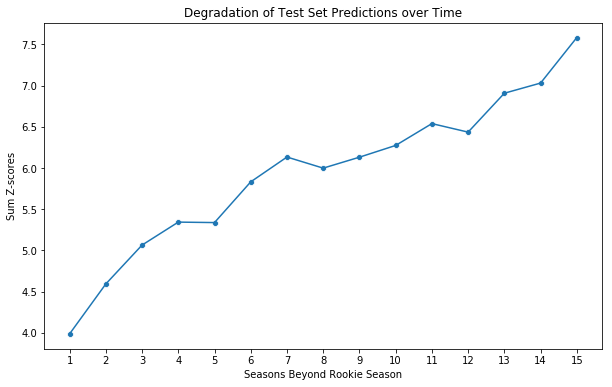

In [65]:
error_by_season = {}

for i in range(1,16):
    error_by_season[i] = np.zeros((1,16))

# aggregate errors by length of prediction into future
for player in test['player_id'].unique():
    pred, error = predict_career(player, 'test', MultiModel)
    error = np.abs(error)[1:,:]

    for i in range(np.min(np.array([15, error.shape[0]]))):
        error_by_season[i+1] = np.vstack((error_by_season[i+1], error[i,:]))

# convert errors into total score
stddevs = np.array(data[features].std())

for season in error_by_season.keys():
    total_preds = error_by_season[season].shape[0] - 1
    error_by_season[season] = np.sum(error_by_season[season], axis = 0) / total_preds
    error_by_season[season] = np.sum(error_by_season[season].reshape(16,) / stddevs)
    

# plot the results
plt.figure(figsize=(10,6))
plt.title('Degradation of Test Set Predictions over Time')
sns.scatterplot(list(error_by_season.keys()), list(error_by_season.values()))
sns.lineplot(list(error_by_season.keys()), list(error_by_season.values()))
plt.ylabel('Sum Z-scores')
plt.xlabel('Seasons Beyond Rookie Season')
plt.xticks(np.linspace(1,15,15));

# Log Results

In [66]:
from datetime import datetime

def log_results(description, feat_dict, results, results_filename = None):
    '''
    INPUT: Description of session, feature_dict, results dataframe
    OUPTUT: Creates an entry in results_log.txt which documents the trial
    '''

    with open('Results_Log/results_log.txt', 'a') as file:
        entry = 'DATETIME: ' + str(datetime.now()) + '\n\n'
        entry += 'DESCRIPTION: ' + description + '\n\n'
        entry += 'RESULTS FILENAME: ' + results_filename + '\n'
        entry += 'TRAIN_MAE: ' + str(results.sum()['train_mae']) + '\n'
        entry += 'TRAIN_SCORE: ' + str(results.sum()['train_zscore']) + '\n'
        entry += 'TEST_MAE: ' + str(results.sum()['test_mae']) + '\n'
        entry += 'TEST_SCORE: ' + str(results.sum()['test_zscore']) + '\n\n'
        file.write(entry)
    
    results.to_csv('Results_Log/results_log.txt', header = results.columns, sep='|', mode='a')
    
    with open('Results_Log/results_log.txt', 'a') as file:
        entry = '\n\nFEATURES\n\n'

        for key in feat_dict.keys():
            entry += key + ': ' + str(feat_dict[key]) + '\n'

        entry += '\n\n****************************\n\n\n'
        
        file.write(entry)
    
    if results_filename:
        results.to_csv(filename)

    print('Entry Logged')
    

In [67]:
# filename = 'Results_Log/Results/GRB3.csv'
# log_results('Using GradientBoost model. All correlated features input to model.',
#             feat_dict, results, results_filename = filename)

# Predict Minutes

Use per 36 stats to predict play time

In [68]:
X_train = train[train['season_index'] >= 1][features + ['minutes_proportion_p1']]
X_test = test[test['season_index'] >= 1][features + ['minutes_proportion_p1']]
y_train = train[train['season_index'] >= 1]['minutes_proportion']
y_test = test[test['season_index'] >= 1]['minutes_proportion']

In [69]:
minutes_model = LinearRegression()

minutes_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Evaluate Individual Season Predictions 

In [70]:
mstd = np.std(sigmoid(np.array(data['minutes_proportion'])))

In [71]:
print("MAE: ", evaluate_general_model(minutes_model, X_train, y_train, sig = True))
print("Z-Score: ", evaluate_general_model(minutes_model, X_train, y_train, sig = True)/mstd)

MAE:  0.08501165588832854
Z-Score:  0.422143887854824


In [72]:
print("MAE: ", evaluate_general_model(minutes_model, X_test, y_test, sig = True))
print("Z-Score: ", evaluate_general_model(minutes_model, X_test, y_test, sig = True)/mstd)

MAE:  0.0837727123427054
Z-Score:  0.41599164390995813


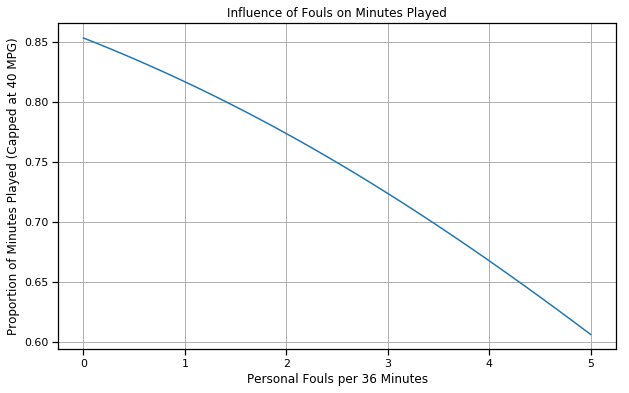

In [99]:
# affect of personal fouls on minutes played
# assumes all other stats are average

syn_data = np.matmul(np.diag(train[features + ['minutes_proportion_p1']].mean()),np.ones(shape = (17,100))).transpose()

syn_data[:,-4] = np.linspace(0,5,num = 100)
syn_data[:,4] = np.zeros(shape = (100,))

syn_preds = minutes_model.predict(syn_data)

plt.figure(figsize=(10,6))
plt.grid()
plt.title('Influence of Fouls on Minutes Played')
sns.lineplot(x = syn_data[:,-4], y = sigmoid(syn_preds))
plt.ylabel('Proportion of Minutes Played (Capped at 40 MPG)')
plt.xlabel('Personal Fouls per 36 Minutes');

### Evaluate full career predictions

In [74]:
# append past minutes proportion to predictions
train_pred = np.hstack((train_pred, np.array(train[train['season_index'] != 0]['minutes_proportion_p1']).reshape(-1,1)))
test_pred = np.hstack((test_pred, np.array(test[test['season_index'] != 0]['minutes_proportion_p1']).reshape(-1,1)))

In [75]:
train_minutes_pred = minutes_model.predict(train_pred)
print("MAE: ", mean_absolute_error(sigmoid(train_minutes_pred), sigmoid(y_train)))
print("Z-Score: ", mean_absolute_error(sigmoid(train_minutes_pred), sigmoid(y_train))/mstd)

MAE:  0.10569634249034476
Z-Score:  0.5248582030859492


In [76]:
test_minutes_pred = minutes_model.predict(test_pred)
print("MAE: ", mean_absolute_error(sigmoid(test_minutes_pred), sigmoid(y_test)))
print("Z-Score: ", mean_absolute_error(sigmoid(test_minutes_pred), sigmoid(y_test))/mstd)

MAE:  0.1055619419012423
Z-Score:  0.5241908076962132


# Train Models on All Data

Now that the models and features are selected train them on all the data

In [77]:
X_all = pd.concat([train[train['season_index'] >= 1], test[test['season_index'] >= 1]], axis = 0)

In [78]:
FinalModel = MultiModelContainer(feat_dict, X_all)

In [79]:
minutes_model = LinearRegression()

minutes_model.fit(X_all[features + ['minutes_proportion_p1']], X_all['minutes_proportion'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Evaluate Results

### Individual Season Prediction Results

In [80]:
# Compile a dataframe of results

results = defaultdict(list)

for key in targets:
    
    feats = feat_dict[key]
    
    if key[-10:] == 'percentage':
        
        train_mae = evaluate_general_model(MultiModel.model_dict[key],
                                                X_all[feats], X_all[key], sig = True)
        stddev = sigmoid(data[key]).std()
        
        results['train_mae'].append(np.round(train_mae, 3))
        results['train_zscore'].append(np.round(train_mae/stddev, 3))
        
    else:
        train_mae = evaluate_general_model(MultiModel.model_dict[key], X_all[feats], X_all[key])
        stddev = data[key].std()
        
        results['train_mae'].append(np.round(train_mae, 3))
        results['train_zscore'].append(np.round(train_mae/stddev, 3))

results = pd.DataFrame(results, index = feat_dict.keys())

In [81]:
results

,train_mae,train_zscore
two_point_percentage,0.032,0.595
two_point_attempts,1.239,0.372
three_point_percentage,0.076,0.413
three_point_attempts,0.632,0.262
free_throw_percentage,0.046,0.483
free_throw_attempts,0.702,0.403
defensive_rebounds,0.579,0.310
offensive_rebounds,0.312,0.254
assists,0.571,0.268
steals,0.210,0.463


### Full Career Prediction Results

In [82]:
switch = 0

for player in train['player_id'].unique():
    pred, error =predict_career(player, 'train', FinalModel)
    error = np.abs(error)[1:,:]
    
    if not switch:
        total_error = error
        total_pred = pred[1:,:]
        switch = 1
    else:
        total_error = np.vstack((total_error, error))
        total_pred = np.vstack((total_pred, pred[1:,:]))
        
for player in test['player_id'].unique():
    pred, error = predict_career(player, 'test', FinalModel)
    error = np.abs(error)[1:,:]
    total_error = np.vstack((total_error, error))
    total_pred = np.vstack((total_pred, pred[1:,:]))
    
        
total_seasons = total_error.shape[0]

total_maes = np.sum(total_error, axis = 0) / total_seasons

total_maes = pd.DataFrame(total_maes.reshape(1,-1), columns = features)

In [83]:
# Compile a dataframe of results

results = defaultdict(list)

for feat in features:
    
    if feat[-10:] == 'percentage':
        
        stddev = sigmoid(data[feat]).std()
        
        results['total_mae'].append(np.round(total_maes[feat][0], 3))
        results['total_zscore'].append(np.round(total_maes[feat][0]/stddev, 3))

        
    else:
        stddev = data[feat].std()
        
        results['total_mae'].append(np.round(total_maes[feat][0], 3))
        results['total_zscore'].append(np.round(total_maes[feat][0]/stddev, 3))

results = pd.DataFrame(results, index = features)

In [84]:
results

,total_mae,total_zscore
age,0.000,0.000
two_point_percentage,0.037,0.691
two_point_attempts,2.012,0.604
three_point_percentage,0.101,0.545
three_point_attempts,1.163,0.482
free_throw_percentage,0.058,0.603
free_throw_attempts,1.055,0.605
defensive_rebounds,0.805,0.431
offensive_rebounds,0.447,0.364
assists,0.861,0.404


In [85]:
results.sum()

total_mae       8.105
total_zscore    6.841
dtype: float64

### Predict Minutes Across Careers

In [86]:
total_pred = np.hstack((total_pred, np.array(X_all['minutes_proportion_p1']).reshape(-1,1)))

In [87]:
total_minutes_pred = minutes_model.predict(total_pred)

In [88]:
mean_absolute_error(sigmoid(total_minutes_pred), sigmoid(X_all['minutes_proportion']))

0.10654874634376672

# Save Models

In [89]:
import pickle

with open('Models/FinalModel.pkl', 'wb') as file:
    pickle.dump(FinalModel, file)
    
with open('Models/MinutesModel.pkl', 'wb') as file:
    pickle.dump(minutes_model, file)